In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## Data Loading

In [5]:
df = pd.read_csv("compas-scores.csv")
print(df.shape)

(11757, 47)


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [7]:
print(df.isnull().sum())


id                             0
name                           0
first                          0
last                           0
compas_screening_date          0
sex                            0
dob                            0
age                            0
age_cat                        0
race                           0
juv_fel_count                  0
decile_score                   0
juv_misd_count                 0
juv_other_count                0
priors_count                   0
days_b_screening_arrest     1180
c_jail_in                   1180
c_jail_out                  1180
c_case_number                742
c_offense_date              2600
c_arrest_date               9899
c_days_from_compas           742
c_charge_degree                0
c_charge_desc                749
is_recid                       0
num_r_cases                11757
r_case_number               8054
r_charge_degree                0
r_days_from_arrest          9297
r_offense_date              8054
r_charge_d

In [11]:
# Convert to datetime objects
df['screening_date'] = pd.to_datetime(df['screening_date'], errors='coerce')
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'], errors='coerce')

In [12]:
# Compute days between initial screening and first re-offense (if any)
df['days_to_recid'] = (df['r_offense_date'] - df['screening_date']).dt.days

In [13]:
# Assign 1 if recidivated within 2 years (730 days), else 0
df['two_year_recid'] = ((df['days_to_recid'] >= 0) & (df['days_to_recid'] <= 730)).astype(int)

In [14]:
df_clean = df[df['screening_date'].notnull()]
df_clean = df_clean[df_clean['two_year_recid'].notnull()]

In [15]:
print(df_clean.columns)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date', 'days_to_recid', 'two_year_recid'],
      dtype='object')


## EDA

In [33]:
features = [
    'age', 'sex', 'race', 'priors_count',
    'juv_fel_count', 'juv_misd_count', 'juv_other_count',
    'c_charge_degree'
]

target = 'two_year_recid'

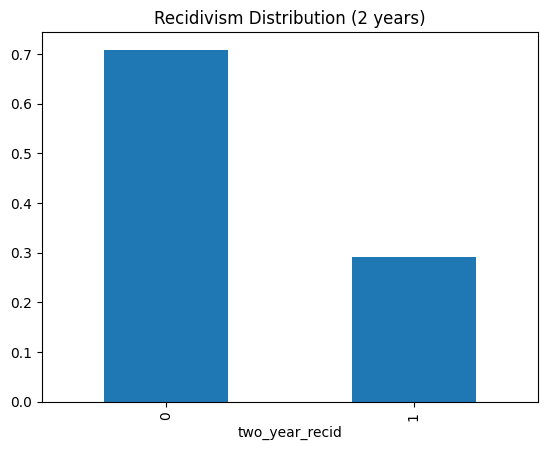

In [20]:
import matplotlib.pyplot as plt

df_clean[target].value_counts(normalize=True).plot(kind='bar')
plt.title("Recidivism Distribution (2 years)")
plt.show()

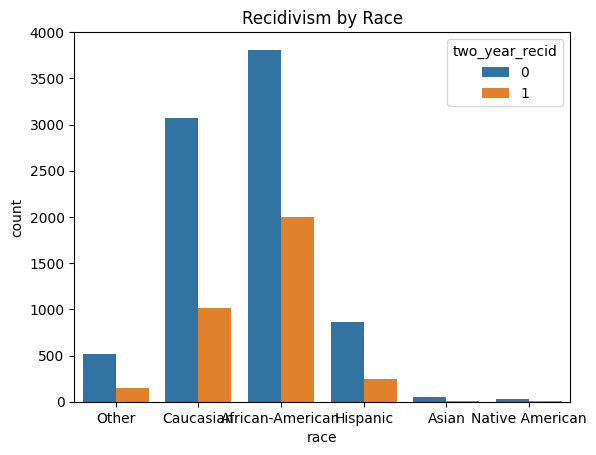

In [21]:
import seaborn as sns
sns.countplot(x='race', hue=target, data=df_clean, )
plt.title("Recidivism by Race")
plt.show()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'decile_score'}>],
       [<Axes: title={'center': 'priors_count'}>,
        <Axes: title={'center': 'juv_fel_count'}>],
       [<Axes: title={'center': 'juv_misd_count'}>,
        <Axes: title={'center': 'juv_other_count'}>]], dtype=object)

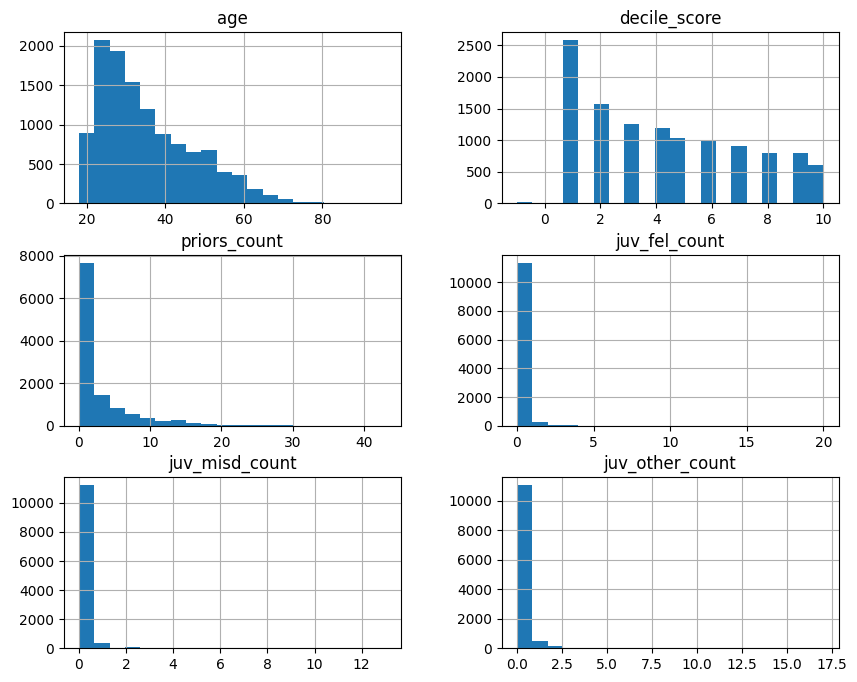

In [26]:
num_cols = ['age', 'decile_score', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
df[num_cols].hist(bins=20, figsize=(10, 8))

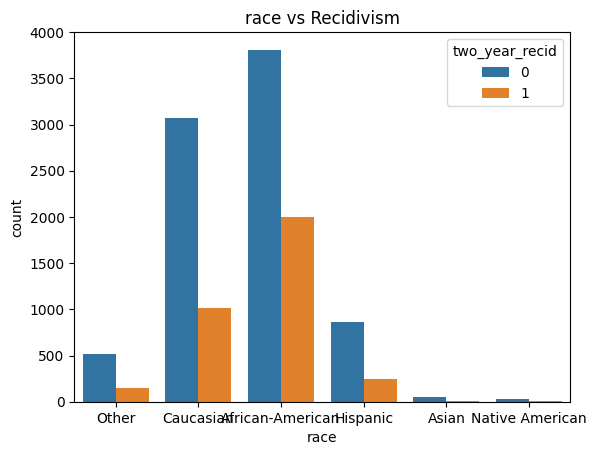

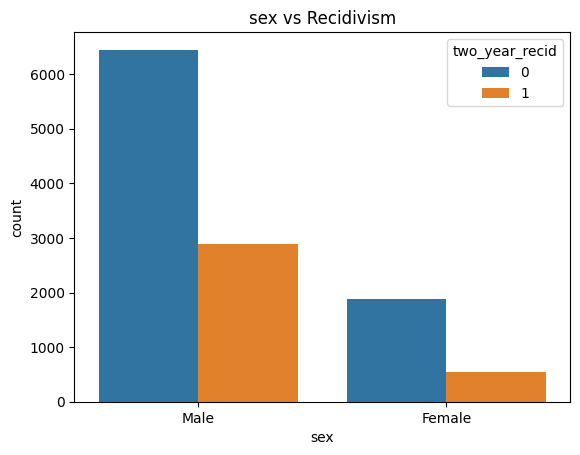

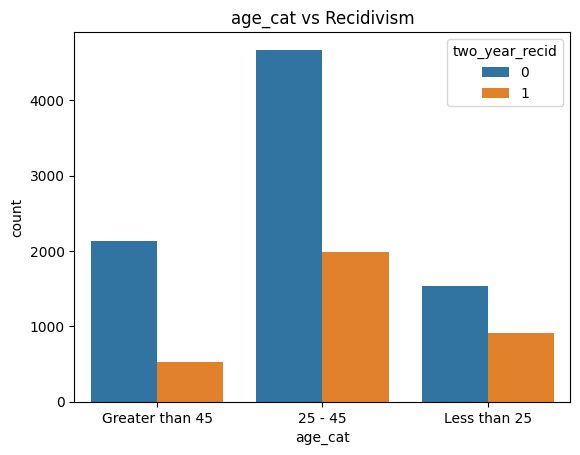

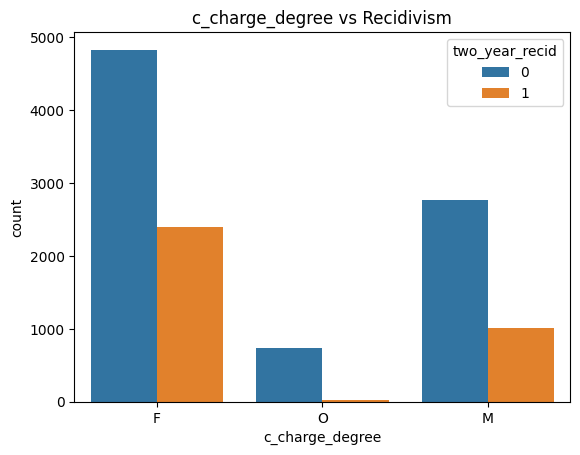

In [27]:
cat_cols = ['race', 'sex', 'age_cat', 'c_charge_degree']
for col in cat_cols:
    sns.countplot(x=col, hue='two_year_recid', data=df)
    plt.title(f'{col} vs Recidivism')
    plt.show()

<Axes: >

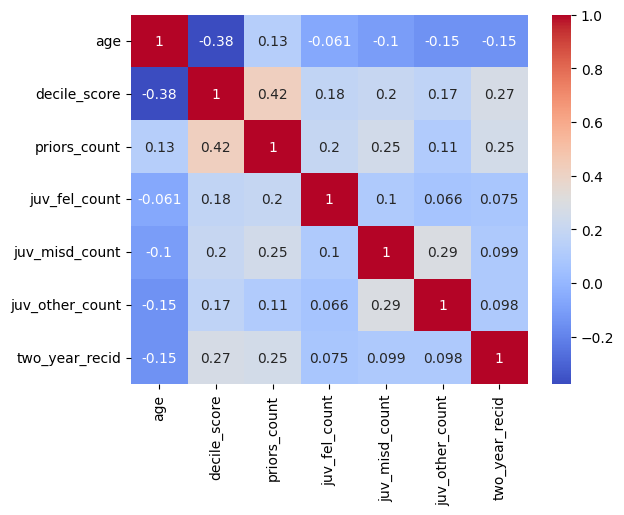

In [28]:
corr = df[num_cols + ['two_year_recid']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

## Model Training

In [39]:
# Define categorical and numerical columns
categorical = ['sex', 'race', 'c_charge_degree']
numerical = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

# Preprocess: one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)

In [40]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize raw models
raw_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Create a new dictionary to store the trained pipelines
trained_pipelines = {}

for name, clf_model in raw_models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf_model)
    ])

    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline # Store the trained pipeline

    print(f"{name} trained successfully.")

Training Logistic Regression...
Logistic Regression trained successfully.
Training Random Forest...
Random Forest trained successfully.


In [46]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

for name, pipeline in trained_pipelines.items(): # Iterate over the trained pipelines
    y_pred = pipeline.predict(X_test) # Predict using the pipeline
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Get probabilities using the pipeline
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.72
ROC-AUC: 0.71
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1667
           1       0.57      0.19      0.28       685

    accuracy                           0.72      2352
   macro avg       0.65      0.56      0.55      2352
weighted avg       0.69      0.72      0.67      2352


Random Forest Results:
Accuracy: 0.68
ROC-AUC: 0.65
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1667
           1       0.45      0.34      0.39       685

    accuracy                           0.68      2352
   macro avg       0.60      0.58      0.59      2352
weighted avg       0.66      0.68      0.67      2352



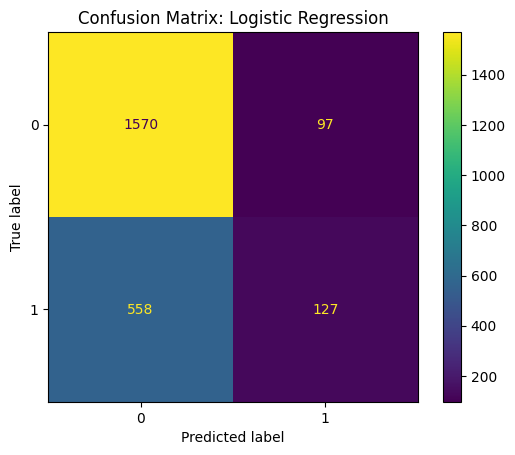

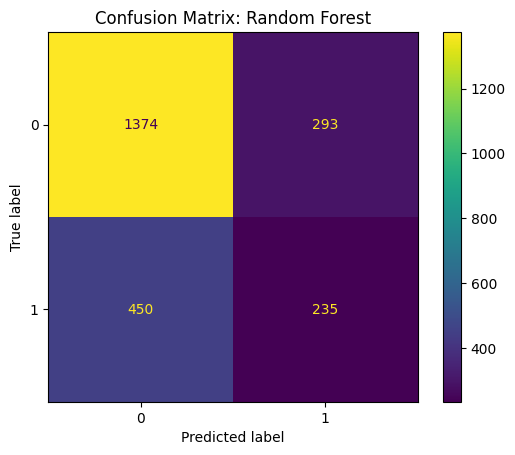

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Ensure plt is imported for show()

for name, pipeline in trained_pipelines.items(): # Iterate over the trained pipelines
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

## Recidivism: Analysis based on Race

In [50]:
import pandas as pd
from sklearn.metrics import confusion_matrix

results = []

for name, pipeline in trained_pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    df_eval = pd.DataFrame({
        'race': X_test['race'],
        'actual': y_test,
        'predicted': y_pred,
        'probability': y_proba
    })

    results.append((name, df_eval))

In [51]:
def compute_group_metrics(df, group_col='race', positive_label=1):
    groups = df[group_col].unique()
    metrics = []

    for group in groups:
        subset = df[df[group_col] == group]
        tn, fp, fn, tp = confusion_matrix(subset['actual'], subset['predicted']).ravel()

        # Compute rates
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics.append({
            'group': group,
            'FPR': fpr,
            'FNR': fnr,
            'TPR': tpr,
            'TNR': tnr,
            'count': len(subset)
        })

    return pd.DataFrame(metrics)

In [52]:
# Compute and display fairness metrics
for name, df_eval in results:
    print(f"\nFairness Metrics for {name}:")
    fairness_df = compute_group_metrics(df_eval)
    print(fairness_df)



Fairness Metrics for Logistic Regression:
              group       FPR       FNR       TPR       TNR  count
0  African-American  0.106757  0.714667  0.285333  0.893243   1115
1             Other  0.010638  1.000000  0.000000  0.989362    128
2         Caucasian  0.021472  0.917051  0.082949  0.978528    869
3          Hispanic  0.018519  0.981818  0.018182  0.981481    217
4   Native American  0.000000  0.500000  0.500000  1.000000      9
5             Asian  0.000000  1.000000  0.000000  1.000000     14

Fairness Metrics for Random Forest:
              group       FPR       FNR       TPR       TNR  count
0  African-American  0.197297  0.600000  0.400000  0.802703   1115
1             Other  0.180851  0.735294  0.264706  0.819149    128
2         Caucasian  0.150307  0.718894  0.281106  0.849693    869
3          Hispanic  0.185185  0.727273  0.272727  0.814815    217
4   Native American  0.142857  1.000000  0.000000  0.857143      9
5             Asian  0.083333  1.000000  0.000000

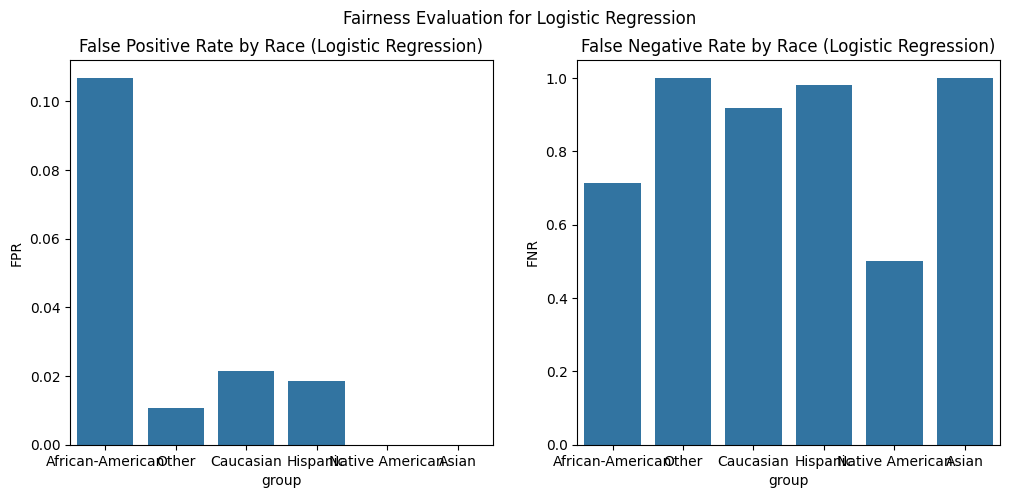

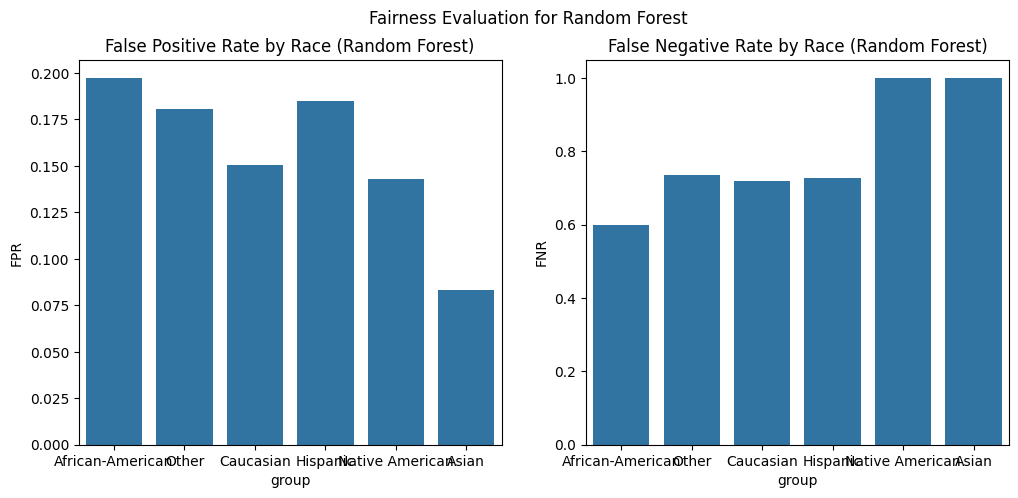

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, df_eval in results:
    fairness_df = compute_group_metrics(df_eval)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(data=fairness_df, x='group', y='FPR', ax=ax[0])
    ax[0].set_title(f'False Positive Rate by Race ({name})')

    sns.barplot(data=fairness_df, x='group', y='FNR', ax=ax[1])
    ax[1].set_title(f'False Negative Rate by Race ({name})')

    plt.suptitle(f'Fairness Evaluation for {name}')
    plt.show()